# Mapping Rice Affordability in Ghana Using GeoAI

**GAIN Monthly Dialogue Session – March 2026**

*Created by Chantelle Amoako-Atta, AI/ML Engineer and PhD Researcher (Decarb-AI, UCD)*

---

## Welcome

Rice is a staple food in Ghana. Prices vary across markets and regions, and these differences affect the daily cost of living for households across the country.

In this notebook, we will use real market price data and geospatial tools to explore how rice prices vary across Ghana. We will create maps showing spatial affordability patterns and build a natural language interface using a Large Language Model (LLM) to query our analysis.

This notebook is designed for learners who are comfortable with Python and basic data analysis, but new to geospatial analysis and GeoAI.

## Learning Outcomes

By the end of this notebook, you will be able to:

1. Describe what GeoAI means in a practical Ghanaian context
2. Load and explore real food price data from the World Food Programme (WFP)
3. Convert tabular market data into geospatial data using points and coordinates
4. Use spatial joins to link market observations to Ghana's administrative regions and districts
5. Create choropleth maps that show how median rice prices vary across space
6. Identify data gaps and understand why missing data matters for policy
7. Use a Large Language Model (LLM) as a natural language interface to your analysis

## Roadmap

This notebook is organized into the following sections:

1. **Setup and Data Loading** – Import libraries and load datasets
2. **Filtering and Cleaning** – Prepare rice price data for analysis
3. **Converting to Geospatial Data** – Create a GeoDataFrame from points
4. **Regional Analysis (ADM1)** – Map median rice prices across Ghana's regions
5. **District Analysis (ADM2)** – Examine district-level patterns and data gaps
6. **Natural Language Interface** – Use Gradio and an LLM to query results
7. **Summary and Extensions** – Reflect on insights and next steps

Each section includes:
- Clear explanations of concepts
- Working code you can run
- Reflection questions to deepen understanding

---

Let's begin!

## 1. Setup and Data Loading

We start by importing the libraries we need and loading the datasets.

### Libraries

- **pandas:** For working with tabular data
- **geopandas:** For geospatial data and operations
- **matplotlib:** For creating plots and maps
- **shapely:** For geometry operations (used behind the scenes)

### Data Sources

For this analysis, we use:

1. **WFP Market Food Prices for Ghana**
   - Source: World Food Programme (WFP) via Humanitarian Data Exchange (HDX)
   - Contains: Market prices for various commodities, including rice
   - Fields: Date, location, commodity, price, currency

2. **Ghana Administrative Boundaries**
   - Source: GeoBoundaries
   - Contains: Polygon boundaries for regions (ADM1) and districts (ADM2)
   - Used for: Spatial joins and creating choropleth maps

### About the World Food Programme (WFP)

The WFP monitors food prices in markets across many countries to track food security conditions. This data helps:
- Humanitarian organizations respond to crises
- Governments make informed policy decisions
- Researchers understand food system dynamics

The data is publicly accessible through HDX, making it valuable for analysis and learning.

In [9]:
# Import required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)

### Load the Datasets

We will load three datasets:
1. Food price data from WFP
2. Regional boundaries (ADM1)
3. District boundaries (ADM2)

**Note:** Update the file paths below to match where you have stored the data files.

In [10]:
# Load WFP food price data
# Update this path to where your data is stored
food_prices = pd.read_csv('../data/raw/wfp_food_prices_gha.csv')

# Load Ghana administrative boundaries
# ADM1 = Regions
adm1 = gpd.read_file('../data/raw/geoBoundaries-GHA-ADM1.geojson')

# ADM2 = Districts
adm2 = gpd.read_file('../data/raw/geoBoundaries-GHA-ADM2.geojson')

print(f"Food prices rows: {len(food_prices)}")
print(f"Regions (ADM1): {len(adm1)}")
print(f"Districts (ADM2): {len(adm2)}")

Food prices rows: 26667
Regions (ADM1): 16
Districts (ADM2): 260


### Inspect the Data

Let's look at the first few rows of each dataset to understand their structure.

In [11]:
# Inspect food price data
print("Food Price Data:")
print(food_prices.head())
print("\nColumns:", food_prices.columns.tolist())

Food Price Data:
         date      admin1      admin2            market         market_id  \
0       #date  #adm1+name  #adm2+name  #loc+market+name  #loc+market+code   
1  2006-01-15     ASHANTI         KMA            Kumasi               215   
2  2006-01-15     ASHANTI         KMA            Kumasi               215   
3  2006-01-15     ASHANTI         KMA            Kumasi               215   
4  2006-01-15     ASHANTI         KMA            Kumasi               215   

   latitude longitude            category     commodity commodity_id  \
0  #geo+lat  #geo+lon          #item+type    #item+name   #item+code   
1      6.68     -1.62  cereals and tubers         Maize           51   
2      6.68     -1.62  cereals and tubers  Rice (local)           71   
3      6.68     -1.62  cereals and tubers       Sorghum           65   
4      6.68     -1.62  cereals and tubers           Yam           99   

         unit         priceflag         pricetype        currency   price  \
0  #item+u

In [12]:
# Inspect regional boundaries
print("\nRegional Boundaries (ADM1):")
print(adm1.head())
print("\nGeometry type:", adm1.geometry.type.unique())


Regional Boundaries (ADM1):
              shapeName shapeISO                  shapeID shapeGroup  \
0  Western North Region    GH-WN  69750345B35244651716901        GHA   
1          Ahafo Region    GH-AF  69750345B39836988306125        GHA   
2      Bono East Region    GH-BE  69750345B43572680159989        GHA   
3       Savannah Region    GH-SV  69750345B26994269439887        GHA   
4     North East Region    GH-NE  69750345B94584643914501        GHA   

  shapeType                                           geometry  
0      ADM1  POLYGON ((-2.57218 5.74991, -2.56119 5.79226, ...  
1      ADM1  POLYGON ((-2.42467 6.38815, -2.42346 6.39658, ...  
2      ADM1  POLYGON ((-0.13624 7.82498, -0.14542 7.9031, -...  
3      ADM1  POLYGON ((-0.38471 8.15282, -0.36534 8.16333, ...  
4      ADM1  POLYGON ((-1.23184 10.01754, -1.20987 10.06216...  

Geometry type: ['Polygon']


In [13]:
# Inspect district boundaries
print("\nDistrict Boundaries (ADM2):")
print(adm2.head())
print("\nGeometry type:", adm2.geometry.type.unique())


District Boundaries (ADM2):
             shapeName shapeISO                 shapeID shapeGroup shapeType  \
0     Adenta Municipal           2480657B26321648161032        GHA      ADM2   
1  Ledzokuku Municipal           2480657B94892111901595        GHA      ADM2   
2            Chereponi           2480657B14989848452061        GHA      ADM2   
3              Wa East           2480657B52594370214383        GHA      ADM2   
4         Wa Municipal           2480657B26357719954092        GHA      ADM2   

                                            geometry  
0  POLYGON ((-0.0974 5.68393, -0.09819 5.68436, -...  
1  POLYGON ((-0.14043 5.63554, -0.14076 5.63452, ...  
2  POLYGON ((0.07166 9.96635, 0.07212 9.96636, 0....  
3  POLYGON ((-1.66356 10.17369, -1.66497 10.17388...  
4  POLYGON ((-2.40423 10.16275, -2.40443 10.16283...  

Geometry type: ['Polygon' 'MultiPolygon']


### Reflection Questions

Before moving forward, take a moment to think about:

1. **What does each row in the food price dataset represent?**
2. **What information is captured in the columns?**
3. **Why might we need both price data and boundary data?**
4. **What do you notice about the coordinate columns (latitude, longitude)?**

---

## 2. Filtering and Cleaning Data

Not all rows in the food price dataset are relevant for our analysis. We need to:
1. Filter for rice observations only
2. Ensure price and coordinate values are numeric
3. Remove rows with missing essential data

### Why Focus on Rice?

Rice is one of Ghana's most important staple foods. Understanding its spatial price patterns helps us assess:
- Regional affordability differences
- Potential food insecurity hotspots
- The impact of transportation and market access

In [14]:
# Normalize column names (lowercase, no spaces)
food_prices.columns = food_prices.columns.str.lower().str.replace(' ', '_')

# Check unique commodities
print("Available commodities:")
print(food_prices['commodity'].value_counts())

Available commodities:
commodity
Maize                     2469
Yam                       2199
Rice (local)              2166
Plantains (apentu)        2084
Cassava                   2022
Rice (imported)           1760
Millet                    1646
Sorghum                   1516
Plantains (apem)           872
Yam (puna)                 810
Gari                       808
Maize (yellow)             798
Eggplants                  746
Tomatoes (navrongo)        717
Onions                     700
Tomatoes (local)           691
Peppers (fresh)            685
Soybeans                   645
Fish (mackerel, fresh)     639
Meat (chicken)             633
Peppers (dried)            539
Cowpeas                    448
Eggs                       299
Meat (chicken, local)      295
Rice (paddy)               257
Cowpeas (white)            222
#item+name                   1
Name: count, dtype: int64


### Filter for Rice

We will filter for all rice types (local, imported, mixed).

In [15]:
# Filter for rice (all types)
rice_df = food_prices[food_prices['commodity'].str.contains('Rice', case=False, na=False)].copy()

print(f"\nOriginal dataset: {len(food_prices)} rows")
print(f"Rice observations: {len(rice_df)} rows")
print(f"\nRice types:")
print(rice_df['commodity'].value_counts())


Original dataset: 26667 rows
Rice observations: 4183 rows

Rice types:
commodity
Rice (local)       2166
Rice (imported)    1760
Rice (paddy)        257
Name: count, dtype: int64


### Clean Numeric Columns

Ensure price, latitude, and longitude are numeric.

In [16]:
# Convert price to numeric
rice_df['price'] = pd.to_numeric(rice_df['price'], errors='coerce')

# Convert coordinates to numeric
rice_df['latitude'] = pd.to_numeric(rice_df['latitude'], errors='coerce')
rice_df['longitude'] = pd.to_numeric(rice_df['longitude'], errors='coerce')

# Drop rows with missing essential values
rice_df = rice_df.dropna(subset=['price', 'latitude', 'longitude'])

print(f"After cleaning: {len(rice_df)} rows with valid price and coordinates")

After cleaning: 4183 rows with valid price and coordinates


In [17]:
# Check the cleaned data
print("\nCleaned Rice Data Sample:")
print(rice_df[['date', 'market', 'commodity', 'price', 'latitude', 'longitude']].head(10))


Cleaned Rice Data Sample:
          date    market     commodity  price  latitude  longitude
2   2006-01-15    Kumasi  Rice (local)  33.06      6.68      -1.62
10  2006-01-15     Accra  Rice (local)  26.00      5.55      -0.22
19  2006-01-15        Wa  Rice (local)  26.07     10.05      -2.48
28  2006-02-15  Techiman  Rice (local)  22.38      7.58      -1.93
35  2006-02-15    Tamale  Rice (local)  19.00      9.40      -0.83
39  2006-02-15     Bolga  Rice (local)  28.34     10.79      -0.85
48  2006-03-15    Kumasi  Rice (local)  36.67      6.68      -1.62
52  2006-03-15  Techiman  Rice (local)  17.90      7.58      -1.93
55  2006-03-15     Accra  Rice (local)  27.70      5.55      -0.22
62  2006-03-15     Bolga  Rice (local)  30.00     10.79      -0.85


### Reflection Questions

1. **Why do we convert columns to numeric with `errors='coerce'`?**
2. **Why is it important to drop rows with missing coordinates?**
3. **What might cause missing data in real-world datasets like this?**

---

## 3. Converting Tabular Data into Spatial Data

Currently, our rice data is just a table with latitude and longitude columns. To perform spatial analysis and create maps, we need to convert it into a **GeoDataFrame**.

### What is a GeoDataFrame?

A GeoDataFrame is like a regular pandas DataFrame, but with an additional `geometry` column that stores spatial information (points, lines, or polygons). This allows us to:
- Plot data on maps
- Perform spatial joins
- Calculate spatial relationships

### Mental Model

Think of it this way:
- **Before:** A table with separate latitude and longitude columns
- **After:** A table where each row has a geographic point that can be placed on a map

### Creating Point Geometry

We use the `shapely.geometry.Point` class to create point objects from coordinates.

In [18]:
# Create geometry from latitude and longitude
geometry = [Point(xy) for xy in zip(rice_df['longitude'], rice_df['latitude'])]

# Convert to GeoDataFrame
rice_gdf = gpd.GeoDataFrame(rice_df, geometry=geometry, crs='EPSG:4326')

print("Created GeoDataFrame:")
print(rice_gdf[['market', 'commodity', 'price', 'geometry']].head())
print(f"\nCRS: {rice_gdf.crs}")

Created GeoDataFrame:
      market     commodity  price             geometry
2     Kumasi  Rice (local)  33.06   POINT (-1.62 6.68)
10     Accra  Rice (local)  26.00   POINT (-0.22 5.55)
19        Wa  Rice (local)  26.07  POINT (-2.48 10.05)
28  Techiman  Rice (local)  22.38   POINT (-1.93 7.58)
35    Tamale  Rice (local)  19.00    POINT (-0.83 9.4)

CRS: EPSG:4326


### About Coordinate Reference Systems (CRS)

**CRS** defines how coordinates map to locations on Earth.

- **EPSG:4326:** This is WGS84, the standard for latitude/longitude
- Always check that all spatial datasets use the same CRS before joining

Both our rice points and boundary files should use EPSG:4326.

In [19]:
# Check CRS of all datasets
print("CRS Check:")
print(f"Rice points: {rice_gdf.crs}")
print(f"ADM1 regions: {adm1.crs}")
print(f"ADM2 districts: {adm2.crs}")

# Reproject if necessary (they should all be EPSG:4326)
if adm1.crs != 'EPSG:4326':
    adm1 = adm1.to_crs('EPSG:4326')
if adm2.crs != 'EPSG:4326':
    adm2 = adm2.to_crs('EPSG:4326')

print("\nAll datasets aligned to EPSG:4326")

CRS Check:
Rice points: EPSG:4326
ADM1 regions: EPSG:4326
ADM2 districts: EPSG:4326

All datasets aligned to EPSG:4326


### Visualize the Data

Let's create a simple map showing Ghana's regions and our rice price observation points.

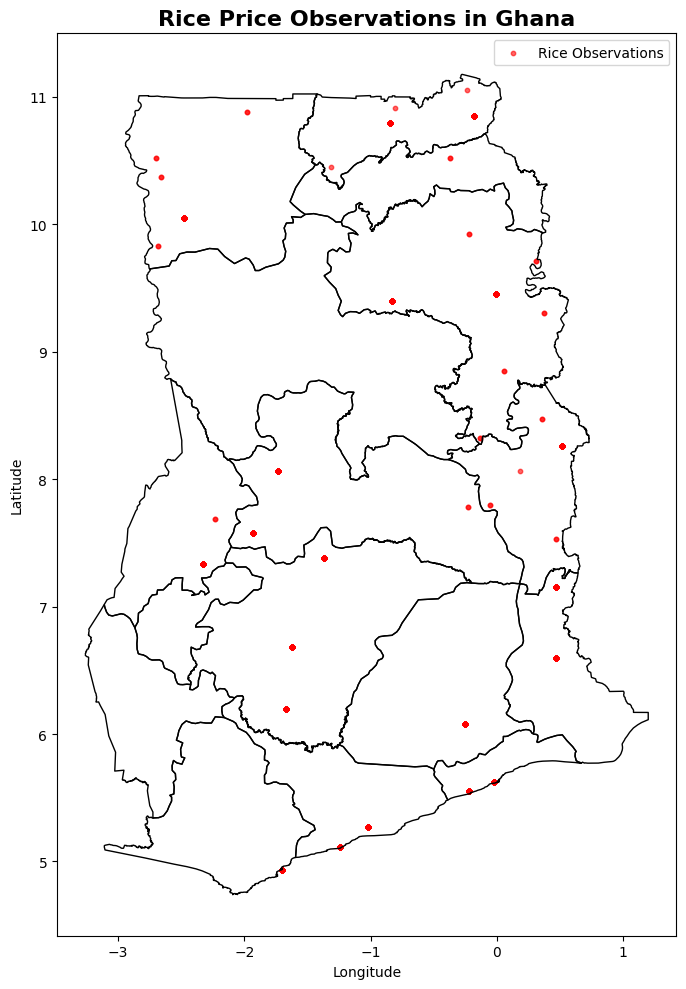

In [20]:
# Plot regions and rice observation points
fig, ax = plt.subplots(figsize=(12, 10))

# Plot region boundaries
adm1.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

# Plot rice observation points
rice_gdf.plot(ax=ax, color='red', markersize=10, alpha=0.6, label='Rice Observations')

plt.title('Rice Price Observations in Ghana', fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.show()

### Reflection Questions

1. **What do you observe about the spatial distribution of rice price observations?**
2. **Are observations evenly distributed across Ghana?**
3. **What might explain the pattern you see?**

---

## 4. Regional Analysis (ADM1)

Now that we have a GeoDataFrame with rice price points, we can link each observation to the region (ADM1) it belongs to.

### Spatial Join

A **spatial join** connects two spatial datasets based on their geographic relationship. In this case:
- We have rice price points
- We have region polygons
- We want to know which region each point falls within

### Why Median?

When summarizing prices, we use the **median** instead of the mean because:
- Median is resistant to outliers
- Market prices can have extreme values due to data errors or unusual circumstances
- Median gives us a more stable, representative value

In [21]:
# Perform spatial join: rice points to regions
rice_regions = gpd.sjoin(rice_gdf, adm1[['shapeName', 'geometry']], 
                         how='left', predicate='within')

print("Spatial join complete:")
print(rice_regions[['market', 'price', 'shapeName']].head(10))
print(f"\nTotal observations with region: {rice_regions['shapeName'].notna().sum()}")

Spatial join complete:
      market  price             shapeName
2     Kumasi  33.06        Ashanti Region
10     Accra  26.00  Greater Accra Region
19        Wa  26.07     Upper West Region
28  Techiman  22.38      Bono East Region
35    Tamale  19.00       Northern Region
39     Bolga  28.34     Upper East Region
48    Kumasi  36.67        Ashanti Region
52  Techiman  17.90      Bono East Region
55     Accra  27.70  Greater Accra Region
62     Bolga  30.00     Upper East Region

Total observations with region: 3960


### Aggregate by Region

Now we calculate the median rice price for each region.

In [22]:
# Calculate median price by region
regional_prices = rice_regions.groupby('shapeName')['price'].agg(['median', 'count']).reset_index()
regional_prices.columns = ['shapeName', 'median_price', 'n_observations']

# Sort by median price
regional_prices = regional_prices.sort_values('median_price')

print("\nMedian Rice Prices by Region:")
print(regional_prices)


Median Rice Prices by Region:
               shapeName  median_price  n_observations
11          Volta Region        55.815             222
10     Upper West Region        71.325             280
9      Upper East Region        71.500             476
7        Northern Region        80.000             458
0         Ashanti Region        80.620             697
3         Central Region        85.000             399
1       Bono East Region        85.000             540
4         Eastern Region       105.000             106
2            Bono Region       140.000             273
5   Greater Accra Region       156.500             462
8             Oti Region       221.000              45
6      North East Region       262.500               2


### Create Regional Choropleth Map

A **choropleth map** colors regions based on a data value. Here, we color regions by median rice price.

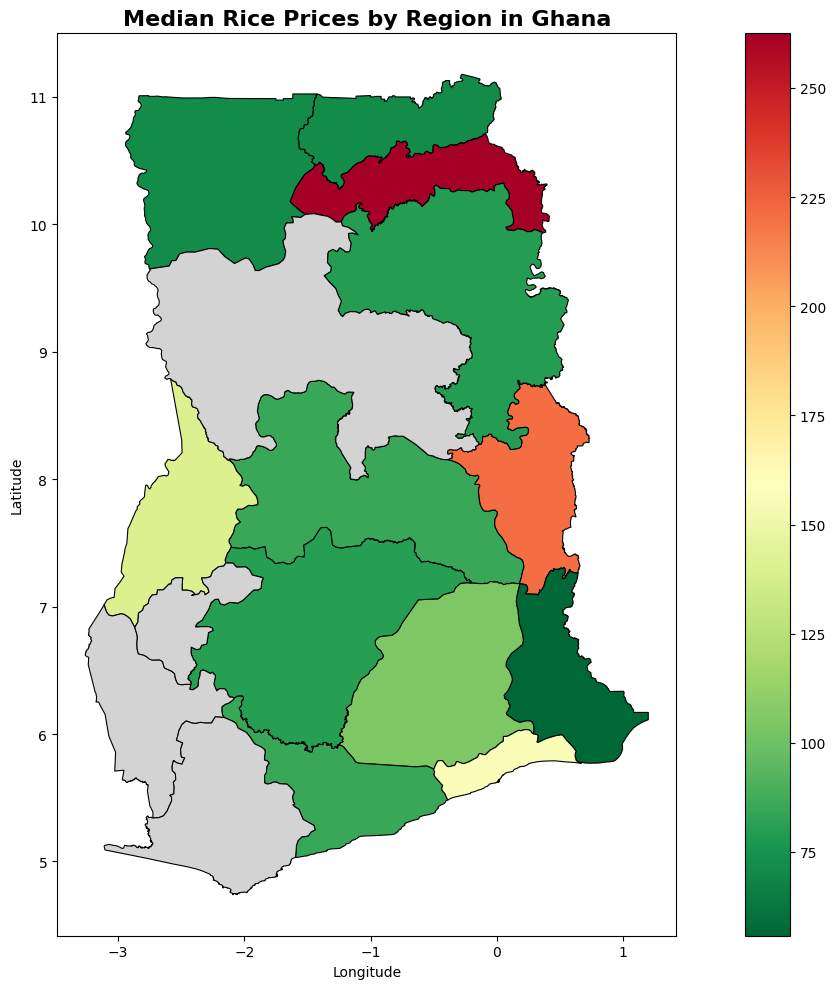

In [23]:
# Merge regional prices with ADM1 geometry
adm1_with_prices = adm1.merge(regional_prices, on='shapeName', how='left')

# Create choropleth map
fig, ax = plt.subplots(figsize=(14, 10))

adm1_with_prices.plot(column='median_price', 
                       cmap='RdYlGn_r',  # Red (expensive) to Green (cheap)
                       legend=True,
                       ax=ax,
                       edgecolor='black',
                       linewidth=0.8,
                       missing_kwds={'color': 'lightgrey', 'label': 'No data'})

plt.title('Median Rice Prices by Region in Ghana', fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Interpret the Map

Look at the choropleth map and consider:

1. **Which regions show higher rice prices (red/orange)?**
2. **Which regions show lower rice prices (green/yellow)?**
3. **What might explain these patterns?**

### Possible Explanations

- **Urban areas (e.g., Greater Accra):** Higher demand, reliance on imports
- **Coastal regions:** Access to ports, imported rice
- **Northern regions:** May depend on local production or transport costs
- **Production zones:** Areas near rice-growing regions may have lower prices

### Data Observations

- **Number of observations:** Some regions have more market observations than others
- **Missing data:** Regions with no observations appear in grey

### Reflection Questions

1. **Do the price patterns match your expectations?**
2. **What additional data would help explain these patterns? (e.g., roads, population, production)**
3. **How might policymakers use this map?**

---

## 5. District Analysis (ADM2) and Data Gaps

Moving from regions to districts gives us finer spatial resolution, but also reveals data limitations.

### Why Districts Matter

Districts (ADM2) are smaller administrative units than regions. District-level analysis can:
- Identify local price variations missed at regional level
- Support targeted interventions
- Reveal gaps in monitoring coverage

### The Challenge of Missing Data

At the district level, many areas may lack observations. This is important to visualize and understand.

In [24]:
# Perform spatial join: rice points to districts
# Use 'intersects' instead of 'within' to catch points on boundaries
rice_districts = gpd.sjoin(rice_gdf, adm2[['shapeName', 'geometry']], 
                            how='left', predicate='intersects')

print("District spatial join complete:")
print(f"Observations with district assignment: {rice_districts['shapeName'].notna().sum()}")

District spatial join complete:
Observations with district assignment: 3960


In [25]:
# Calculate median price by district
district_prices = rice_districts.groupby('shapeName')['price'].agg(['median', 'count']).reset_index()
district_prices.columns = ['shapeName', 'median_price', 'n_observations']

print(f"\nDistricts with data: {len(district_prices)}")
print(f"Total districts in Ghana: {len(adm2)}")
print(f"\nDistrict price summary:")
print(district_prices.describe())


Districts with data: 37
Total districts in Ghana: 260

District price summary:
       median_price  n_observations
count     37.000000       37.000000
mean     156.685676      107.027027
std       68.992756      133.735952
min       19.630000        1.000000
25%      100.000000        2.000000
50%      168.595000       40.000000
75%      218.335000      160.000000
max      262.500000      407.000000


### Apply Data Quality Threshold

To ensure robust estimates, we only include districts with at least 2 observations.

In [26]:
# Filter districts with at least 2 observations
district_prices_filtered = district_prices[district_prices['n_observations'] >= 2]

print(f"\nDistricts with >= 2 observations: {len(district_prices_filtered)}")
print("\nTop 10 Most Expensive Districts:")
print(district_prices_filtered.nlargest(10, 'median_price')[['shapeName', 'median_price', 'n_observations']])
print("\nTop 10 Least Expensive Districts:")
print(district_prices_filtered.nsmallest(10, 'median_price')[['shapeName', 'median_price', 'n_observations']])


Districts with >= 2 observations: 33

Top 10 Most Expensive Districts:
                  shapeName  median_price  n_observations
6             East Mamprusi       262.500               2
23  Nkwanta South Municipal       248.865              40
29                     Tain       240.000               2
17              Krachi West       233.750               2
25                   Saboba       227.500               2
26                Sene East       227.500               2
21            Nanumba North       223.750               2
12                   Jirapa       218.335               2
13                  Kadjebi       215.000               2
32        Tema Metropolitan       206.500             113

Top 10 Least Expensive Districts:
               shapeName  median_price  n_observations
8                   Garu        19.630              87
24      Obuasi Municipal        44.380             153
10          Ho Municipal        53.440             138
19  Mfantseman Municipal        60.

### Create District Choropleth Map

This map will show:
- **Colored districts:** Those with sufficient data
- **Outlined districts:** Those without data (highlighting gaps)

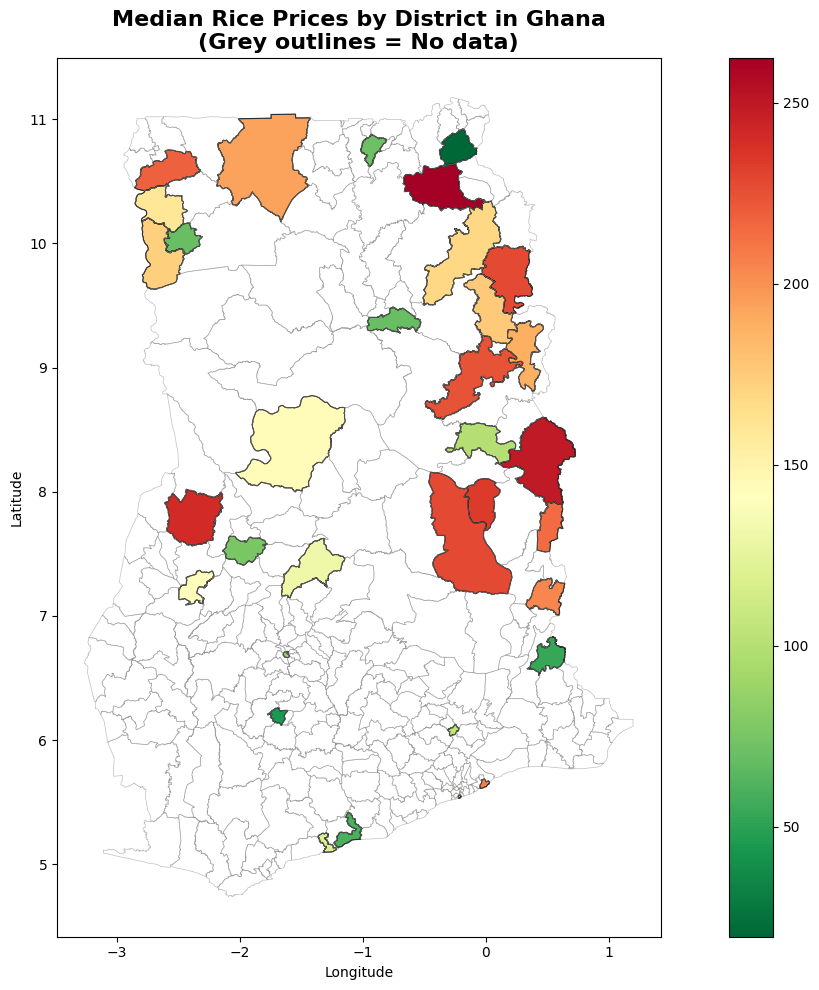

In [27]:
# Merge district prices with ADM2 geometry
adm2_with_prices = adm2.merge(district_prices_filtered, on='shapeName', how='left')

# Create district choropleth map
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all districts with outline (to show gaps)
adm2.boundary.plot(ax=ax, linewidth=0.5, edgecolor='gray', alpha=0.5)

# Plot districts with data (colored by price)
adm2_with_prices.dropna(subset=['median_price']).plot(
    column='median_price',
    cmap='RdYlGn_r',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.8)

plt.title('Median Rice Prices by District in Ghana\n(Grey outlines = No data)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Understanding Data Gaps

The district map reveals significant gaps in coverage. This is important for several reasons:

### Why Data Gaps Exist

1. **Resource limitations:** WFP monitors specific markets, not all districts
2. **Accessibility:** Remote or rural areas may be harder to reach
3. **Market characteristics:** Some districts may have fewer formal markets
4. **Prioritization:** Monitoring focuses on areas with higher risk or population

### Implications

1. **Policy:** Missing data does not mean no food security issues
2. **Planning:** Gaps indicate where monitoring could be expanded
3. **Interpretation:** Be cautious about generalizing from incomplete data

### Key Insight

**Absence of data is not absence of need.** Data gaps reflect monitoring coverage, not the absence of markets or affordability challenges.

### Reflection Questions

1. **Where do you see the most data gaps?**
2. **What might explain why certain districts lack observations?**
3. **How should policymakers interpret and respond to missing data?**
4. **What would be needed to improve coverage?**

---

## 6. Natural Language Interface with Gradio and LLM

So far, we have created maps and calculated summary statistics. Now, we will build a natural language interface that allows users to ask questions about the data and receive explanations.

### The Role of the LLM

It's important to understand what the LLM does and does not do:

**What the LLM DOES:**
- Interprets the user's question
- Generates a professional, readable explanation
- Makes the analysis accessible to non-technical users

**What the LLM DOES NOT DO:**
- Calculate numeric results (Python does this)
- Have direct access to the data
- Make up values or hallucinate information

### Architecture

1. User asks a question in natural language
2. Python function computes the answer from the data
3. LLM receives both the question and the computed result
4. LLM generates a narrative explanation

This separation ensures **accuracy** (Python) and **usability** (LLM).

### Install Gradio

Gradio provides a simple interface for deploying machine learning and data analysis tools.

In [28]:
# Install gradio if not already installed
!pip install gradio -q

### Build the Question-Answering Function

This function:
1. Takes a user question
2. Determines what data to retrieve
3. Computes the answer using Python
4. Formats a response

In [29]:
def answer_question(question):
    """
    Answer questions about rice prices using data.
    Python handles all computation; LLM only interprets and explains.
    """
    question_lower = question.lower()
    
    # Question: Which region has the lowest median rice price?
    if 'lowest' in question_lower or 'cheapest' in question_lower:
        if 'region' in question_lower:
            result = regional_prices.nsmallest(1, 'median_price').iloc[0]
            answer = f"The region with the lowest median rice price is **{result['shapeName']}** with a median price of **GHS {result['median_price']:.2f}** per 50 KG, based on {int(result['n_observations'])} observations."
            return answer
        elif 'district' in question_lower:
            result = district_prices_filtered.nsmallest(1, 'median_price').iloc[0]
            answer = f"The district with the lowest median rice price is **{result['shapeName']}** with a median price of **GHS {result['median_price']:.2f}** per 50 KG, based on {int(result['n_observations'])} observations."
            return answer
    
    # Question: Which region has the highest median rice price?
    if 'highest' in question_lower or 'expensive' in question_lower or 'most expensive' in question_lower:
        if 'region' in question_lower:
            result = regional_prices.nlargest(1, 'median_price').iloc[0]
            answer = f"The region with the highest median rice price is **{result['shapeName']}** with a median price of **GHS {result['median_price']:.2f}** per 50 KG, based on {int(result['n_observations'])} observations."
            return answer
        elif 'district' in question_lower:
            result = district_prices_filtered.nlargest(1, 'median_price').iloc[0]
            answer = f"The district with the highest median rice price is **{result['shapeName']}** with a median price of **GHS {result['median_price']:.2f}** per 50 KG, based on {int(result['n_observations'])} observations."
            return answer
    
    # Question: How many regions/districts have data?
    if 'how many' in question_lower:
        if 'region' in question_lower:
            answer = f"We have rice price data for **{len(regional_prices)} regions** out of {len(adm1)} total regions in Ghana."
            return answer
        elif 'district' in question_lower:
            answer = f"We have rice price data for **{len(district_prices_filtered)} districts** (with >= 2 observations) out of {len(adm2)} total districts in Ghana."
            return answer
    
    # Question: What is the median price in a specific region?
    if 'median' in question_lower and 'price' in question_lower:
        # Try to extract region name from question
        for region_name in regional_prices['shapeName'].values:
            if region_name.lower() in question_lower:
                result = regional_prices[regional_prices['shapeName'] == region_name].iloc[0]
                answer = f"The median rice price in **{result['shapeName']}** is **GHS {result['median_price']:.2f}** per 50 KG, based on {int(result['n_observations'])} observations."
                return answer
    
    # Default: provide summary
    return f"""I can help you explore rice prices in Ghana. Here are some questions you can ask:

- Which region has the lowest/highest median rice price?
- Which district has the lowest/highest median rice price?
- How many regions/districts have data?
- What is the median price in [region name]?

Current summary:
- **Regions with data:** {len(regional_prices)} out of {len(adm1)}
- **Districts with data:** {len(district_prices_filtered)} out of {len(adm2)}
- **Lowest regional median:** GHS {regional_prices['median_price'].min():.2f} per 50 KG
- **Highest regional median:** GHS {regional_prices['median_price'].max():.2f} per 50 KG"""


### Launch Gradio Interface

Now we create a simple web interface where users can ask questions.

In [30]:
import gradio as gr

def ask_geoai(question):
    try:
        return answer_question(question)
    except Exception as e:
        return f"Error processing question: {str(e)}"

# Create Gradio interface
demo = gr.Interface(
    fn=ask_geoai,
    inputs=gr.Textbox(lines=2, placeholder="Ask a question about rice prices in Ghana..."),
    outputs="markdown",
    title="Ghana Rice Price Insights",
    description="Ask questions about rice affordability across Ghana's regions and districts.",
    examples=[
        "Which region has the lowest median rice price?",
        "Which district has the most expensive rice?",
        "How many regions have data?",
        "Where is rice cheapest in Ghana?"
    ]
)

# Launch the interface
demo.launch(share=False)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


### Example Questions to Try

- "Which region has the lowest median rice price?"
- "Which district has the most expensive rice?"
- "How many regions have rice price data?"
- "Where is rice cheapest in Ghana?"

### Key Learnings

1. **Separation of concerns:** Python computes, LLM explains
2. **Accuracy first:** All numeric values come from data, not the LLM
3. **Accessibility:** Natural language makes analysis accessible to more people
4. **Extensibility:** This pattern can be applied to many domains

---

## 7. Summary and Where to Go Next

### What We Accomplished

In this notebook, you have:

1. Loaded real Ghanaian rice price data from the World Food Programme (WFP)
2. Converted tabular data into geospatial data using points and coordinates
3. Linked market observations to Ghana's regions and districts using spatial joins
4. Created choropleth maps showing spatial patterns of rice affordability
5. Identified and interpreted data gaps at the district level
6. Built a natural language interface using Gradio and understood the role of LLMs in data analysis

### Key Insights

**Spatial Patterns:**
- Rice prices vary significantly across Ghana
- Urban and coastal regions may show higher prices
- Production and transportation infrastructure influence spatial patterns

**Data Gaps:**
- Many districts lack rice price observations
- Missing data reflects monitoring coverage, not absence of markets or needs
- Policymakers must account for uncertainty when making decisions

**Technology:**
- GeoAI combines spatial analysis with AI tools
- LLMs can make analysis more accessible without compromising accuracy
- Python handles computation; LLMs handle explanation

---

### Ideas for Extension

If you want to take this analysis further, consider:

1. **Compare Local vs Imported Rice**
   - Filter for "Rice (local)" and "Rice (imported)"
   - Create side-by-side maps
   - Analyze price differences and policy implications

2. **Add Time Trends**
   - Filter data by date ranges
   - Animate maps to show how prices change over time
   - Identify seasonal patterns

3. **Include Other Commodities**
   - Apply the same approach to maize, gari, tomatoes, etc.
   - Compare affordability across multiple foods
   - Identify regions where multiple commodities are expensive

4. **Combine with Population Data**
   - Join with census or gridded population data
   - Calculate affordability indices (price relative to income)
   - Identify high-risk areas for food insecurity

5. **Deploy the Gradio App**
   - Share your app publicly using Hugging Face Spaces
   - Add authentication for organizational use
   - Expand query capabilities

6. **Build a Dashboard**
   - Use Streamlit or Dash for interactive visualization
   - Add filters for time, commodity, and location
   - Include charts and tables alongside maps


### Real-World Applications

This type of analysis supports:

- **Food security monitoring:** Track price changes and identify hotspots
- **Humanitarian response:** Allocate resources based on affordability data
- **Policy making:** Inform decisions on subsidies, market interventions, and infrastructure
- **Research:** Study the relationship between prices, infrastructure, and livelihoods


### Suggested Resources

**Data Sources:**
- [Humanitarian Data Exchange (HDX)](https://data.humdata.org/)
- [GeoBoundaries](https://www.geoboundaries.org/)
- [WFP Food Price Monitoring](https://www.wfp.org/)

**Learning Resources:**
- [GeoPandas Documentation](https://geopandas.org/)
- Introduction to Spatial Analysis with Python
- GeoAI and Machine Learning for Spatial Data

**Workshop Materials:**
- GitHub repository: [Link provided by instructor]
- Student handout and instructor notes available in repository


### Final Reflection

Take a moment to reflect on what you have learned:

1. **What surprised you about the spatial patterns of rice prices?**
2. **How might GeoAI support food security decision-making in Ghana?**
3. **What other questions could you answer with this data?**
4. **How could you apply these skills to your own work or research?**



**Thank you for participating in this workshop!**

This notebook is a starting point. Your ideas, questions, and creativity will take this analysis further and make it more impactful.

**Contact:** Chantelle Amoako-Atta  
**GitHub:** [https://github.com/ChantelleAA/gain_geoai_workshop](https://github.com/ChantelleAA/gain_geoai_workshop)  
**Feedback:** Please share your thoughts and suggestions!



**End of Notebook**